# Diffusion MNIST - Modèle Mono-Classe (6)

Ce notebook implémente un modèle de diffusion à partir du dataset MNIST en se focalisant uniquement sur une classe. Ici nous avons choisi la génération de 6.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Architecture du modèle

Nous utilisons la même architecture UNet que dans le modèle multi-classes, avec des embeddings temporels sinusoïdaux.

In [ ]:
def sinusoidal_time_embedding(timesteps, dim):
    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half, dtype=torch.float32) / half
    ).to(timesteps.device)

    args = timesteps[:, None] * freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

In [ ]:
class Double_Conv(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.ReLU(inplace=True)

        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

    def forward(self, x, t_emb=None):
        x = self.act(self.conv1(x))

        if t_emb is not None:
            t_added = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
            x = x + t_added

        x = self.act(self.conv2(x))
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_ch, time_emb_dim=256):
        super().__init__()

        self.time_emb_dim = time_emb_dim

        # MLP for timestep embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.ReLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )

        # Contracting path with time embedding
        self.down_convolution_1 = Double_Conv(num_ch, 64, time_emb_dim)
        self.down_convolution_2 = Double_Conv(64, 128, time_emb_dim)
        self.down_convolution_3 = Double_Conv(128, 256, time_emb_dim)
        self.down_convolution_4 = Double_Conv(256, 512, time_emb_dim)
        self.down_convolution_5 = Double_Conv(512, 1024, time_emb_dim)

        self.max_pool2d = nn.MaxPool2d(2, 2)

        # Expanding path
        self.up_transpose_1 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.up_convolution_1 = Double_Conv(1024, 512, time_emb_dim)

        self.up_transpose_2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up_convolution_2 = Double_Conv(512, 256, time_emb_dim)

        self.up_transpose_3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up_convolution_3 = Double_Conv(256, 128, time_emb_dim)

        self.up_transpose_4 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up_convolution_4 = Double_Conv(128, 64, time_emb_dim)

        self.out = nn.Conv2d(64, num_ch, 1)

    def forward(self, x, t):
        # ---- time embedding ----
        t_emb = sinusoidal_time_embedding(t, self.time_emb_dim)
        t_emb = self.time_mlp(t_emb)

        # ---- UNet encoder ----
        down_1 = self.down_convolution_1(x, t_emb)
        down_2 = self.max_pool2d(down_1)

        down_3 = self.down_convolution_2(down_2, t_emb)
        down_4 = self.max_pool2d(down_3)

        down_5 = self.down_convolution_3(down_4, t_emb)
        down_6 = self.max_pool2d(down_5)

        down_7 = self.down_convolution_4(down_6, t_emb)
        down_8 = self.max_pool2d(down_7)

        down_9 = self.down_convolution_5(down_8, t_emb)

        # ---- UNet decoder ----
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1), t_emb)

        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1), t_emb)

        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1), t_emb)

        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1), t_emb)

        return self.out(x)

## Préparation des données - Dataset filtré

Nous créons un dataset contenant uniquement les images du chiffre 6 depuis MNIST.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import MNIST

batch_size = 64

transform = T.Compose([
    T.Resize((16, 16)),
    T.ToTensor(),
])

# Charger le dataset MNIST complet
mnist_full = MNIST(root='data', train=True, download=True, transform=transform)

print(f"Dataset MNIST complet: {len(mnist_full)} images")

Dataset MNIST complet: 60000 images


On filtre le dataset MNIST en créant un dataLoader uniquement de 6.

In [ ]:
class FilteredMNIST(Dataset):
    def __init__(self, original_dataset, target_digit=6):
        self.data = []
        self.labels = []
        
        for img, label in original_dataset:
            if label == target_digit:
                self.data.append(img)
                self.labels.append(label)
        
        print(f"Dataset filtré créé avec {len(self.data)} images du chiffre {target_digit}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Créer le dataset filtré avec uniquement les 6
train_ds_6 = FilteredMNIST(mnist_full, target_digit=6)
train_dl_6 = DataLoader(train_ds_6, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

print(f"Nombre de batches: {len(train_dl_6)}")

Dataset filtré créé avec 5918 images du chiffre 6
Nombre de batches: 93


## Visualisation du dataset

Affichons quelques exemples du chiffre 6 depuis notre dataset filtré.

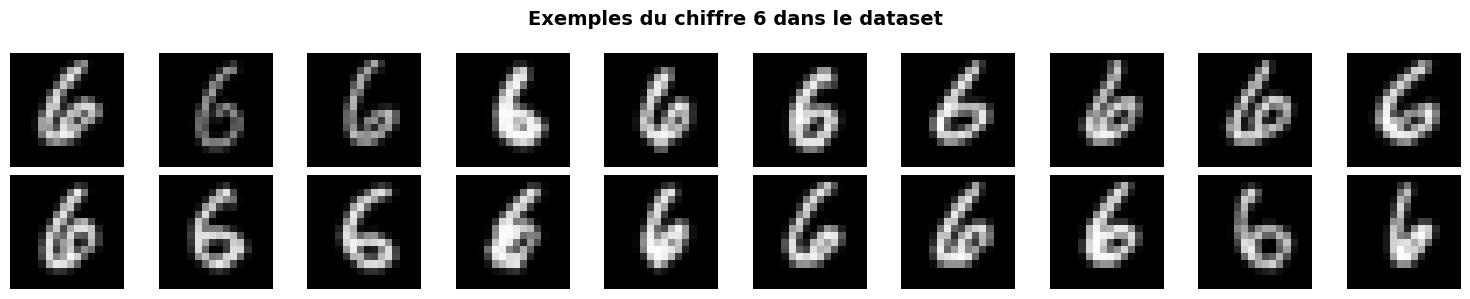

In [7]:
import matplotlib.pyplot as plt

# Afficher quelques exemples du dataset
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Exemples du chiffre 6 dans le dataset', fontsize=14, fontweight='bold')
axes = axes.flatten()

for i in range(20):
    img, label = train_ds_6[i]
    axes[i].imshow(img.squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Visualisation du processus de bruitage

Créons une animation montrant comment une image du chiffre 6 est progressivement bruitée selon le processus de diffusion forward.

Paramètres utilisés: T=50, β_min=0.0001, β_max=0.2000
GIF sauvegardé: mnist_single_class_6_noising_process.gif


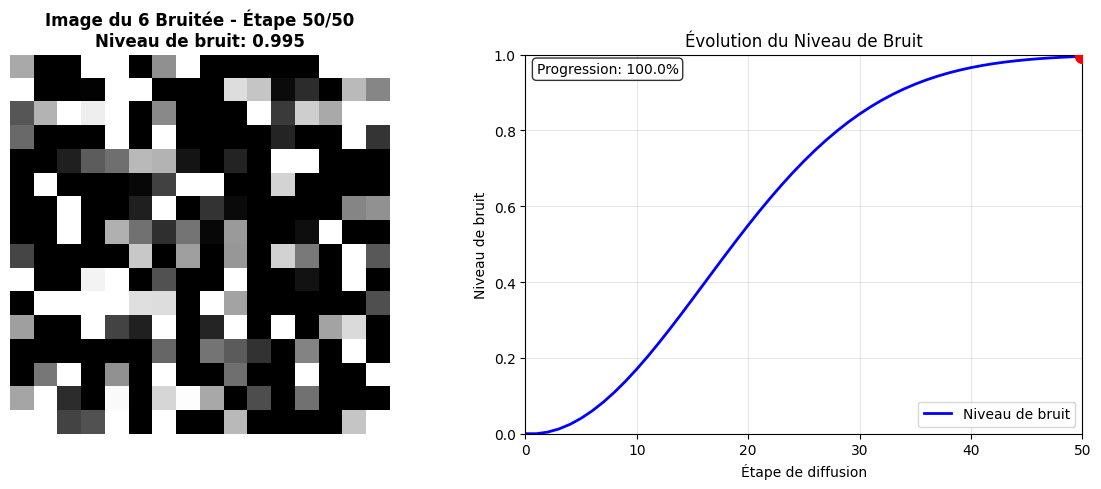

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import numpy as np

def create_noising_gif_single_class():
    # Paramètres de diffusion pour la démonstration
    T = 50
    beta_list_demo = torch.linspace(0.0001, 0.2, steps=T).to(device)
    sigma_list_demo = 1 - beta_list_demo
    alpha_bar_demo = torch.cumprod(sigma_list_demo, dim=0)
    
    # Prendre une image d'exemple du dataset (un 6)
    sample_image, sample_label = train_ds_6[0]
    sample_image = sample_image.unsqueeze(0).to(device)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    def animate(frame):
        ax1.clear()
        ax2.clear()
        
        t = frame
        
        if t == 0:
            noisy_image = sample_image
            noise_level = 0.0
        else:
            alpha_bar_t = alpha_bar_demo[t-1]
            noise = torch.randn_like(sample_image)
            noisy_image = torch.sqrt(alpha_bar_t) * sample_image + torch.sqrt(1 - alpha_bar_t) * noise
            noise_level = 1 - alpha_bar_t.item()
        
        img_display = noisy_image.squeeze().cpu().numpy()
        
        ax1.imshow(img_display, cmap='gray', vmin=0, vmax=1)
        ax1.set_title(f'Image du 6 Bruitée - Étape {t}/{T}\nNiveau de bruit: {noise_level:.3f}', 
                     fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        steps = np.arange(0, T+1)
        noise_levels = np.zeros(T+1)
        noise_levels[1:] = 1 - alpha_bar_demo.cpu().numpy()
        
        ax2.plot(steps[:t+1], noise_levels[:t+1], 'b-', linewidth=2, label='Niveau de bruit')
        ax2.scatter(t, noise_level, color='red', s=100, zorder=5)
        ax2.set_xlim(0, T)
        ax2.set_ylim(0, 1)
        ax2.set_xlabel('Étape de diffusion')
        ax2.set_ylabel('Niveau de bruit')
        ax2.set_title('Évolution du Niveau de Bruit')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        progress = t / T
        ax2.text(0.02, 0.98, f'Progression: {progress:.1%}', 
                transform=ax2.transAxes, fontsize=10, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    anim = animation.FuncAnimation(fig, animate, frames=T+1, interval=300, repeat=True)
    
    print(f"Paramètres utilisés: T={T}, β_min={beta_list_demo[0]:.4f}, β_max={beta_list_demo[-1]:.4f}")
    
    try:
        writer = PillowWriter(fps=4)
        anim.save('mnist_single_class_6_noising_process.gif', writer=writer)
        print("GIF sauvegardé: mnist_single_class_6_noising_process.gif")
    except Exception as e:
        print(f"Le GIF ne sera pas sauvegardé: {e}")
    
    return anim

anim = create_noising_gif_single_class()
plt.tight_layout()
plt.show()

## Paramètres de diffusion

Configuration du processus de diffusion avec T étapes et un schedule de bruit linéaire.

In [ ]:
T = 50
beta_list = torch.linspace(0.0001, 0.2, steps=T).to(device)
sigma_list = 1 - beta_list

print(f"Nombre d'étapes de diffusion: {T}")
print(f"β_min = {beta_list[0]:.4f}, β_max = {beta_list[-1]:.4f}")

Nombre d'étapes de diffusion: 50
β_min = 0.0001, β_max = 0.2000


## Fonction d'entraînement

La fonction d'entraînement implémente le processus de diffusion forward et entraîne le modèle à prédire le bruit ajouté.

In [ ]:
def train(epochs, dataloader, model, optimizer, loss_fct, T, sigma_list, device):
    model.train()

    if not torch.is_tensor(sigma_list):
        sigma_list = torch.tensor(sigma_list, dtype=torch.float32, device=device)
    else:
        sigma_list = sigma_list.to(device).float()

    alpha_bar = torch.cumprod(sigma_list, dim=0)

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for x0, _labels in dataloader:
            x0 = x0.to(device)

            B = x0.size(0)
            t = torch.randint(1, T + 1, (B,), device=device, dtype=torch.long)

            alpha_bar_t = alpha_bar[t - 1].view(B, 1, 1, 1)   # [B,1,1,1]

            noise = torch.randn_like(x0, device=device)

            x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1.0 - alpha_bar_t) * noise

            optimizer.zero_grad()

            predicted_noise = model(x_t, t)

            loss = loss_fct(noise, predicted_noise)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / (num_batches if num_batches > 0 else 1)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

## Entraînement du modèle

Entraînons le modèle sur les images du chiffre 6 uniquement.

In [ ]:
epochs = 100
learning_rate = 0.001

model_6 = UNet(num_ch=1).to(device)
optimizer_6 = torch.optim.Adam(model_6.parameters(), lr=learning_rate)
loss_fct_6 = torch.nn.MSELoss()

train(epochs, train_dl_6, model_6, optimizer_6, loss_fct_6, T, sigma_list, device)

torch.save(model_6.state_dict(), 'unet_mnist_6only_50steps.pt')
print("\nModèle sauvegardé: unet_mnist_6only_50steps.pt")

Epoch [1/100], Loss: 0.2467
Epoch [10/100], Loss: 0.0380
Epoch [20/100], Loss: 0.0321
Epoch [30/100], Loss: 0.0305
Epoch [40/100], Loss: 0.0275
Epoch [50/100], Loss: 0.0293
Epoch [60/100], Loss: 0.0272
Epoch [70/100], Loss: 0.0280
Epoch [80/100], Loss: 0.0273
Epoch [90/100], Loss: 0.0289
Epoch [100/100], Loss: 0.0270

Modèle sauvegardé: unet_mnist_6only_50steps.pt


## Génération d'échantillons

Implémentons le processus de débruitage (reverse diffusion) pour générer de nouvelles images du chiffre 6.

In [ ]:
def generate_samples(model, num_samples, T, beta_list, sigma_list, device):
    model.eval()
    
    x_t = torch.randn(num_samples, 1, 16, 16).to(device)
    
    generated_samples = []
    sigma_bar_list = torch.cumprod(sigma_list, dim=0)
    
    with torch.no_grad():
        for t in reversed(range(1, T + 1)):
            t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
            
            predicted_noise = model(x_t, t_tensor)
            
            beta_t = beta_list[t - 1]
            sigma_t = sigma_list[t - 1]
            sigma_bar_t = sigma_bar_list[t - 1]
            
            z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
            
            x_t = (1 / torch.sqrt(sigma_t)) * (x_t - (1-sigma_t)/torch.sqrt(1 - sigma_bar_t) * predicted_noise) + torch.sqrt(beta_t) * z
            
            generated_samples.append(x_t.cpu().numpy())
    
    return x_t, generated_samples

## Génération et visualisation - 100 chiffres 6

Générons 100 images du chiffre 6 et affichons-les en grille.

Génération de 100 échantillons du chiffre 6...


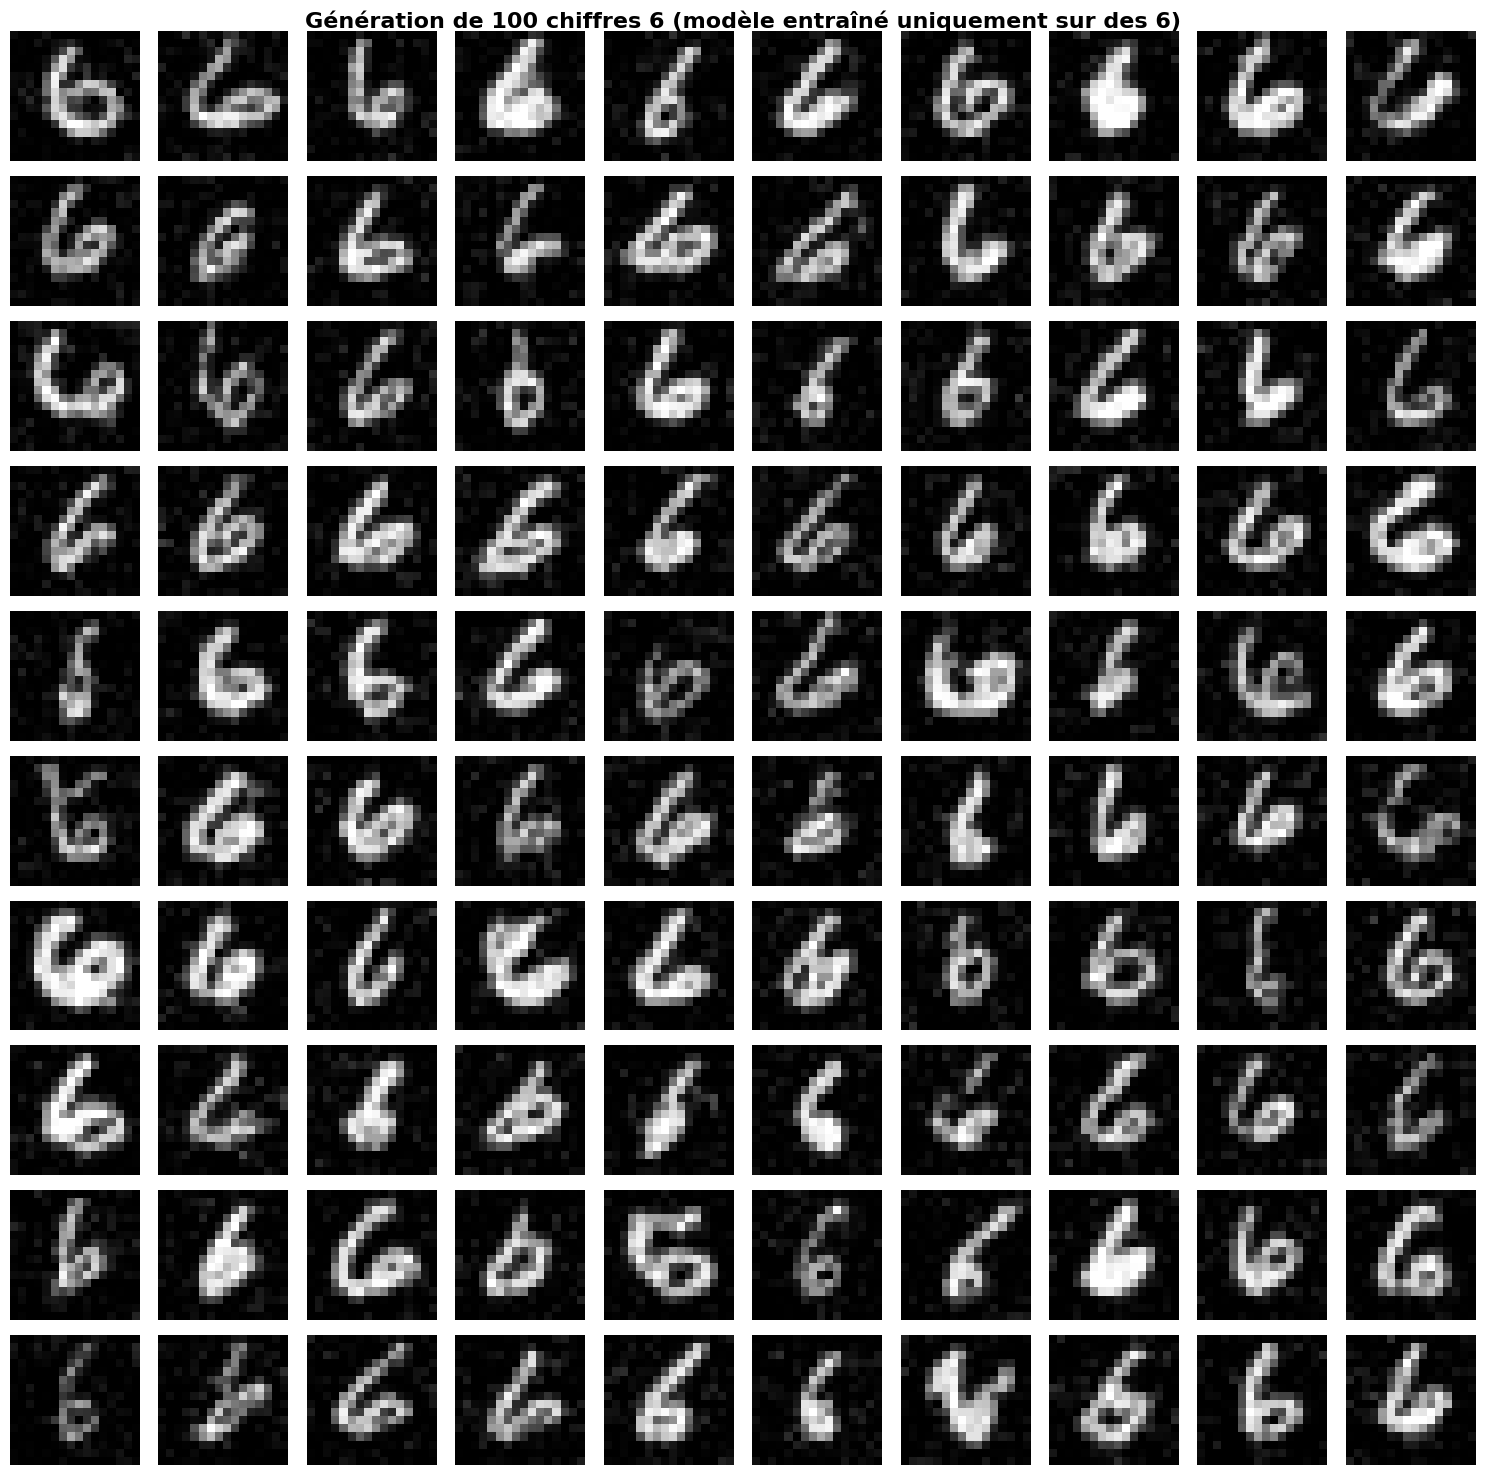

✓ 100 images générées avec succès


In [ ]:
import matplotlib.pyplot as plt
import math

num_samples = 100

print(f"Génération de {num_samples} échantillons du chiffre 6...")
final_x_t, intermediates = generate_samples(model_6, num_samples, T, beta_list, sigma_list, device)

if torch.is_tensor(final_x_t):
    final_imgs = final_x_t.detach().cpu().clamp(0.0, 1.0).squeeze(1).numpy()
else:
    final_imgs = np.array(final_x_t)

N = final_imgs.shape[0]

cols = 10
rows = 10
fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
fig.suptitle('Génération de 100 chiffres 6 (modèle entraîné uniquement sur des 6)', 
             fontsize=16, fontweight='bold')
axes = axes.flatten()

for i in range(rows*cols):
    ax = axes[i]
    if i < N:
        ax.imshow(final_imgs[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"✓ {num_samples} images générées avec succès")

## Visualisation du processus de débruitage

Affichons le processus complet de débruitage pour quelques échantillons, montrant l'évolution du bruit pur vers des images claires.

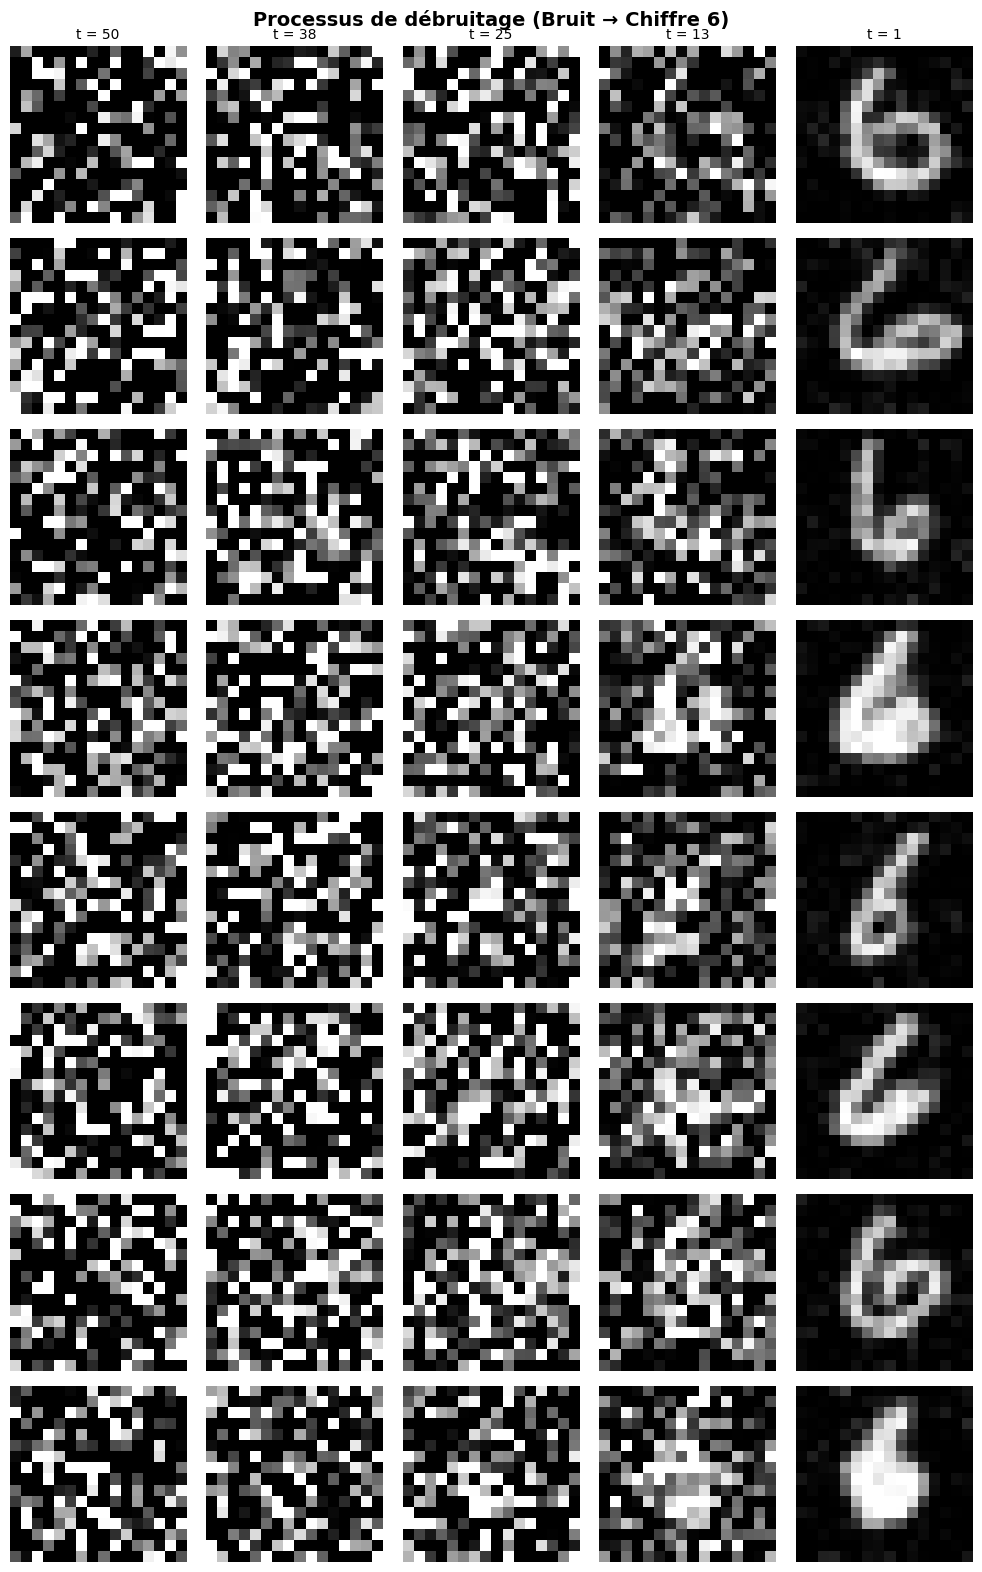

✓ Visualisation du processus de débruitage pour 8 échantillons


In [ ]:
if intermediates:
    inter_list = []
    for step in intermediates:
        if torch.is_tensor(step):
            step_np = step.detach().cpu().squeeze(1).numpy()
        else:
            step_np = np.array(step)
            if step_np.ndim == 4:
                step_np = step_np.squeeze(1)
        inter_list.append(step_np)
    inter_np = np.stack(inter_list, axis=0) 

    K = min(8, N) 
    
    timesteps_to_show = [0, T//4, T//2, 3*T//4, T-1]
    
    fig, axes = plt.subplots(K, len(timesteps_to_show), figsize=(len(timesteps_to_show)*2, K*2))
    fig.suptitle('Processus de débruitage (Bruit → Chiffre 6)', fontsize=14, fontweight='bold')
    
    for r in range(K):
        for c, t_idx in enumerate(timesteps_to_show):
            ax = axes[r, c] if K > 1 else axes[c]
            ax.imshow(inter_np[t_idx, r], cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
            if r == 0:
                ax.set_title(f't = {T - t_idx}', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Visualisation du processus de débruitage pour {K} échantillons")

## Expérimentation avec différents paramètres

Testons maintenant avec un schedule de bruit différent (beta_max = 0.5).

In [ ]:
T_exp = 50
beta_list_exp = torch.linspace(0.0001, 0.5, steps=T_exp).to(device)
sigma_list_exp = 1 - beta_list_exp

model_6_exp = UNet(num_ch=1).to(device)
optimizer_6_exp = torch.optim.Adam(model_6_exp.parameters(), lr=learning_rate)
loss_fct_6_exp = torch.nn.MSELoss()

train(epochs, train_dl_6, model_6_exp, optimizer_6_exp, loss_fct_6_exp, T_exp, sigma_list_exp, device)

torch.save(model_6_exp.state_dict(), 'unet_mnist_6only_50steps_beta05.pt')
print("\nModèle sauvegardé: unet_mnist_6only_50steps_beta05.pt")

Epoch [1/100], Loss: 0.2058
Epoch [10/100], Loss: 0.0363
Epoch [20/100], Loss: 0.0231
Epoch [30/100], Loss: 0.0224
Epoch [40/100], Loss: 0.0218
Epoch [50/100], Loss: 0.0188
Epoch [60/100], Loss: 0.0189
Epoch [70/100], Loss: 0.0194
Epoch [80/100], Loss: 0.0194
Epoch [90/100], Loss: 0.0209
Epoch [100/100], Loss: 0.0193

Modèle sauvegardé: unet_mnist_6only_50steps_beta05.pt


Génération de 100 échantillons avec β_max = 0.5...


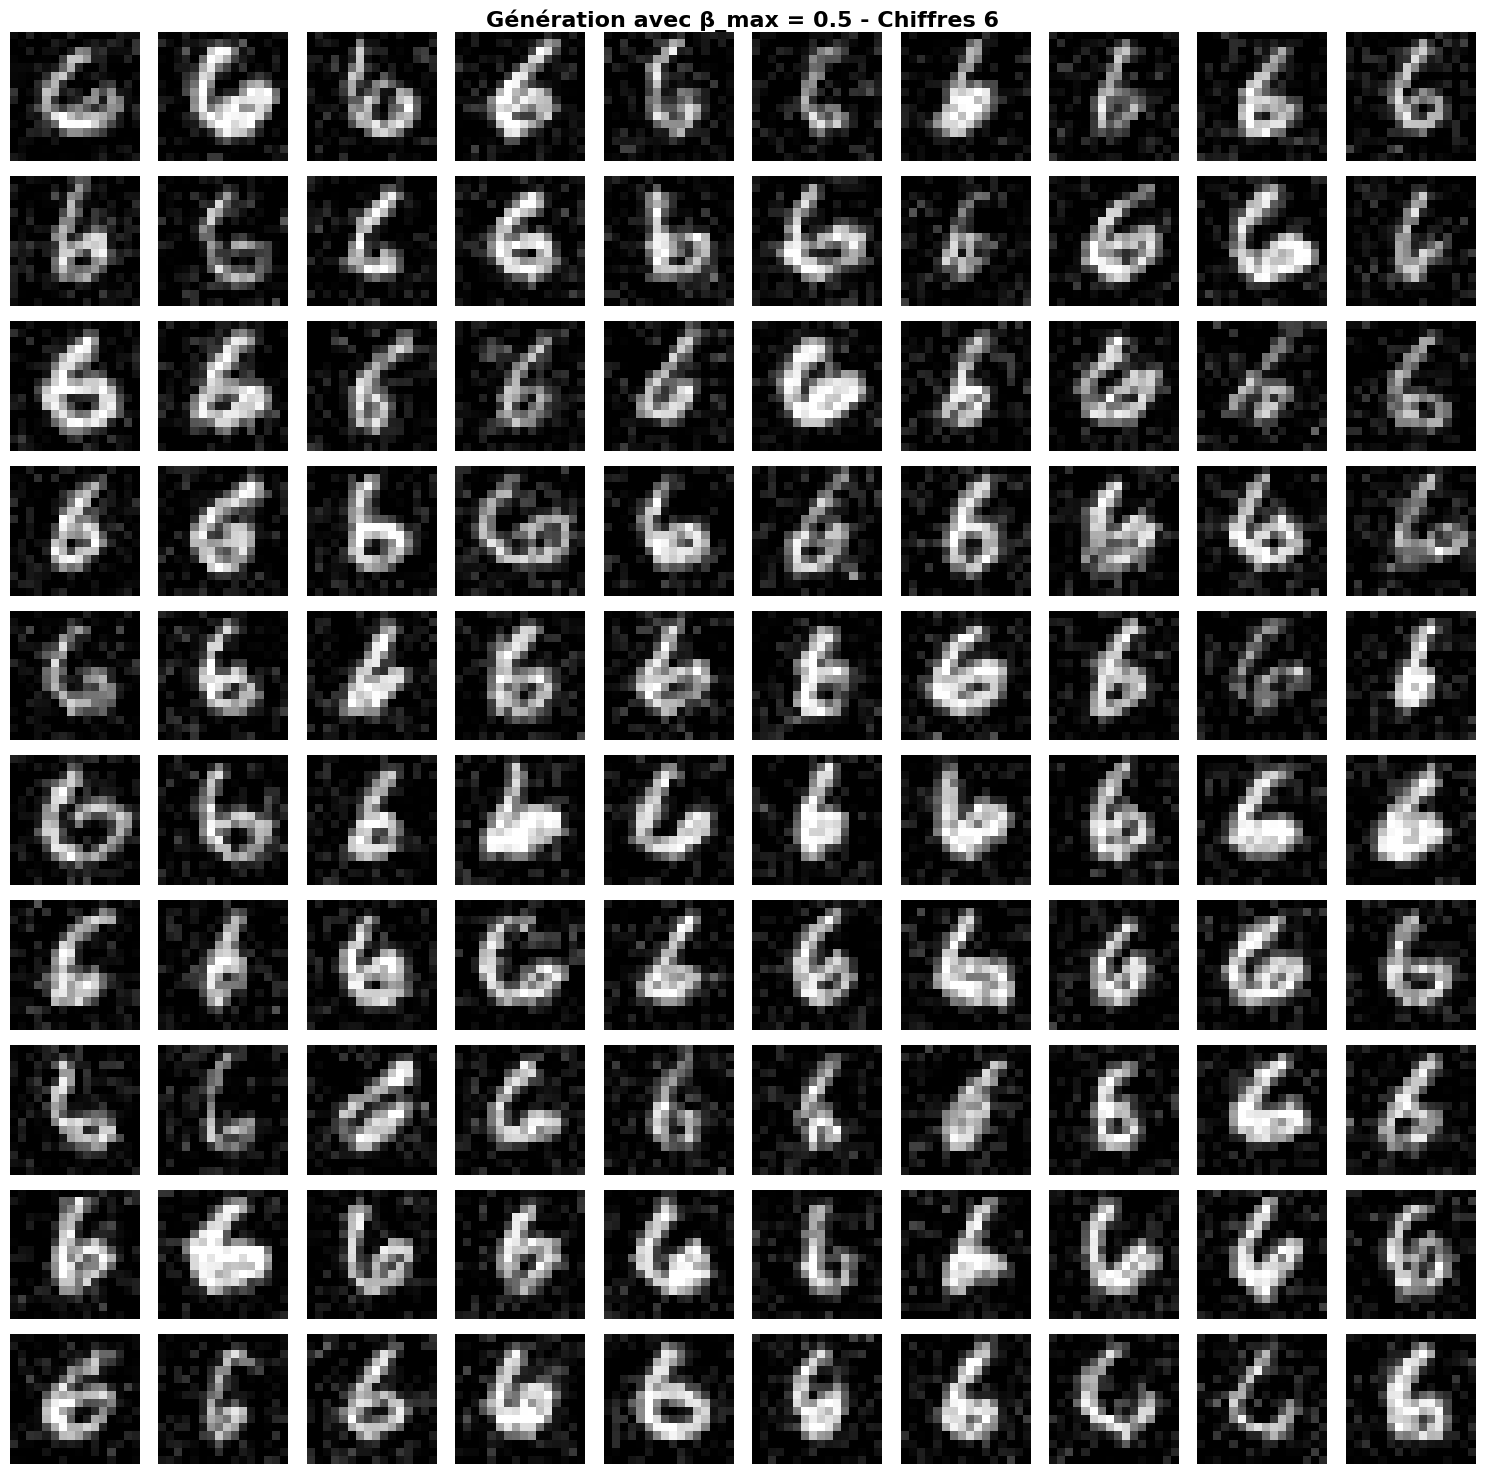

✓ Génération terminée avec β_max = 0.5


In [ ]:
print(f"Génération de {num_samples} échantillons avec β_max = 0.5...")
final_x_t_exp, _ = generate_samples(model_6_exp, num_samples, T_exp, beta_list_exp, sigma_list_exp, device)

if torch.is_tensor(final_x_t_exp):
    final_imgs_exp = final_x_t_exp.detach().cpu().clamp(0.0, 1.0).squeeze(1).numpy()
else:
    final_imgs_exp = np.array(final_x_t_exp)

fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
fig.suptitle('Génération avec β_max = 0.5 - Chiffres 6', 
             fontsize=16, fontweight='bold')
axes = axes.flatten()

for i in range(rows*cols):
    ax = axes[i]
    if i < num_samples:
        ax.imshow(final_imgs_exp[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"✓ Génération terminée avec β_max = 0.5")

## Comparaison des deux modèles

Comparons visuellement les résultats des deux configurations (β_max = 0.2 vs β_max = 0.5).

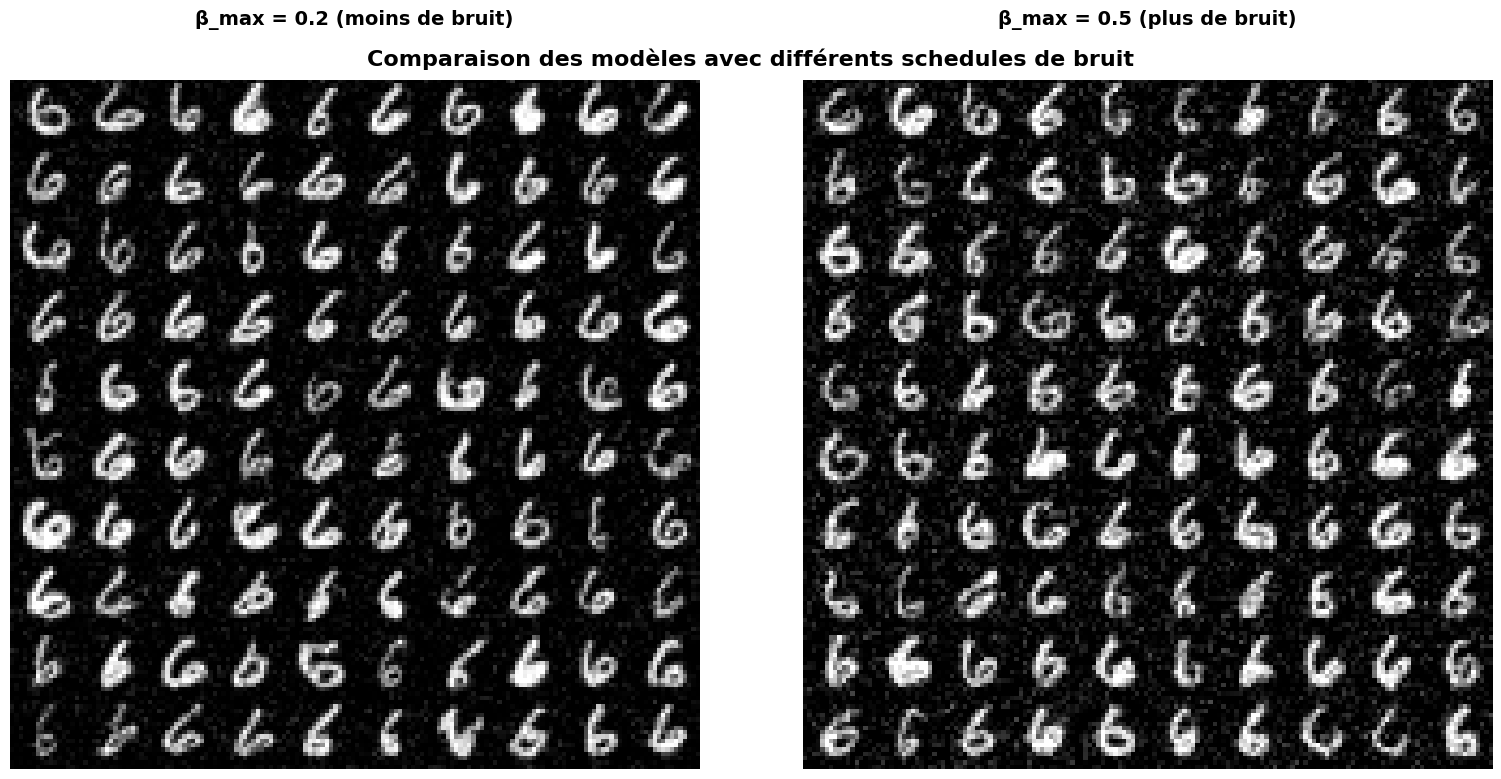

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

grid1 = np.concatenate([np.concatenate(final_imgs[i*10:(i+1)*10], axis=1) for i in range(10)], axis=0)
grid2 = np.concatenate([np.concatenate(final_imgs_exp[i*10:(i+1)*10], axis=1) for i in range(10)], axis=0)

ax1.imshow(grid1, cmap='gray', vmin=0, vmax=1)
ax1.set_title('β_max = 0.2 (moins de bruit)', fontsize=14, fontweight='bold', pad=40)
ax1.axis('off')

ax2.imshow(grid2, cmap='gray', vmin=0, vmax=1)
ax2.set_title('β_max = 0.5 (plus de bruit)', fontsize=14, fontweight='bold', pad=40)
ax2.axis('off')

plt.suptitle('Comparaison des modèles avec différents schedules de bruit', 
             fontsize=16, fontweight='bold', y=0.92)
plt.tight_layout()
plt.show()